In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding, \
ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score
from sklearn.exceptions import ConvergenceWarning

from xgboost import XGBClassifier, XGBRFClassifier, plot_importance
import matplotlib.pyplot as plt
import warnings

import pickle

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import add_model, test_model, get_timeseries_table

from seaborn import heatmap

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [11]:
def model_each_feature(model, verbose=1, save=True,
                   vectorization=None,
                   regularization=None,
                   regularization_strength=None,
                   class_imbalance=None):
    """Takes an unfitted model and optional entries for hyperparameter table and returns 
    the fitted model.
    fits model on each of X_t_clicks, X_t_activities, X_t_product, and all 3 features in X_t.
    Loads hyperparameter table from disk, writes entries for each of the 4 datasets.
    if save=False, will not save over hyperparameter table file on disk.
    if verbose=1, display the hyperparamter table.  
    If verbose = 2+, also display model.score_ and confusion matrix"""
    try:
        h_table = pd.read_csv('hyper_parameter_table.csv')
    except:
        h_table = None
    for train_X, val_X, feature in ((X_t_clicks, X_val_clicks, 'clicks'), 
                                 (X_t_activities, X_val_activities, 'activities'),
                                 (X_t_product, X_val_product, 'activities_x_clicks'),
                                 (X_t, X_val, 'clicks_activities_product_assessments_module')):
        model.fit(train_X, y_t)

        h_table = add_model(model, train_X, y_t, val_X, y_val, 
                                features = feature,
                                table=h_table, 
                                class_imbalance=class_imbalance)
        
        if verbose > 1:
            print(feature)
            test_model(model, validate_X, y_val, plot_confusion=True)
            
    if save:
        h_table.to_csv('hyper_parameter_table.csv', index=False)
    if verbose > 0:
        display(h_table)
    return model

In [8]:
df

,assess_submitted_1,assess_score_1,assess_submitted_2,assess_score_2,assess_submitted_3,assess_score_3,assess_submitted_4,assess_score_4,assess_submitted_5,assess_score_5,...,sum_click_134,activities_x_clicks_134,final_result,module_AAA,module_BBB,module_CCC,module_DDD,module_EEE,module_FFF,module_GGG
registration,,,,,,,,,,,,,,,,,,,,,
AAA2013J11391,-1.0,78.0,-1.0,85.0,-2.0,80.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1,0,0,0,0,0,0
AAA2013J28400,3.0,70.0,-2.0,68.0,4.0,70.0,0.0,0.0,0.0,0.0,...,38.0,418.0,1,1,0,0,0,0,0,0
AAA2013J31604,-2.0,72.0,-3.0,71.0,-2.0,74.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1,0,0,0,0,0,0
AAA2013J32885,7.0,69.0,21.0,30.0,7.0,63.0,0.0,0.0,0.0,0.0,...,3.0,3.0,1,1,0,0,0,0,0,0
AAA2013J38053,0.0,79.0,10.0,69.0,0.0,74.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGG2014J691787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,1
GGG2014J692171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,232.0,1,0,0,0,0,0,0,1
GGG2014J693046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,1


In [9]:
prediction_window = 135

df = get_timeseries_table(prediction_window=prediction_window,
                         binary_labels=True, one_hot_modules=True)

X = df.drop(columns=['final_result'])
y = df['final_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111)

X_train_clicks = X_train.loc[:,X_train.columns.str.startswith('sum_click')]
X_test_clicks = X_test.loc[:,X_test.columns.str.startswith('sum_click')]
X_t_clicks = X_t.loc[:,X_t.columns.str.startswith('sum_click')]
X_val_clicks = X_val.loc[:,X_val.columns.str.startswith('sum_click')]

X_train_activities = X_train.loc[:,X_train.columns.str.startswith('sum_activities')]
X_test_activities = X_test.loc[:,X_test.columns.str.startswith('sum_activities')]
X_t_activities = X_t.loc[:,X_t.columns.str.startswith('sum_activities')]
X_val_activities = X_val.loc[:,X_val.columns.str.startswith('sum_activities')]

X_train_product = X_train.loc[:,X_train.columns.str.startswith('activities_x_clicks')]
X_test_product = X_test.loc[:,X_test.columns.str.startswith('activities_x_clicks')]
X_t_product = X_t.loc[:,X_t.columns.str.startswith('activities_x_clicks')]
X_val_product = X_val.loc[:,X_val.columns.str.startswith('activities_x_clicks')]

assessments merged:  1


h_table = None

In [13]:
model = LogisticRegression(random_state=111)
model_each_feature(model, verbose=0)

LogisticRegression(random_state=111)

In [14]:
class_imbalance = 'balanced weights'
model = LogisticRegression(class_weight='balanced', random_state=111)
model_each_feature(model, class_imbalance=class_imbalance, verbose=0)

LogisticRegression(class_weight='balanced', random_state=111)

In [15]:
model = DecisionTreeClassifier(random_state=111)
model_each_feature(model, verbose=0)

DecisionTreeClassifier(random_state=111)

In [16]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=111)
model_each_feature(model, verbose=0, class_imbalance=class_imbalance)

DecisionTreeClassifier(class_weight='balanced', random_state=111)

In [17]:
model = RandomForestClassifier(random_state=111)
model_each_feature(model, verbose=0)

RandomForestClassifier(random_state=111)

In [18]:
model = RandomForestClassifier(class_weight='balanced', random_state=111)
model_each_feature(model, verbose=0, class_imbalance=class_imbalance)

RandomForestClassifier(class_weight='balanced', random_state=111)

In [19]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111)
model_each_feature(model, verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=111, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [20]:
pd.read_csv('hyper_parameter_table.csv')

,model,vectorization,features,regularization,regularization_strength,class_imbalance,train_accuracy,val_accuracy,train_f1_score,val_f1_score
0,XGBClassifier,None,clicks_activities_product_assessments_module,None,None,None,0.972078,0.841369,0.978431,0.881079
1,RandomForestClassifier,None,clicks_activities_product_assessments_module,None,None,None,1.000000,0.828260,1.000000,0.877360
2,RandomForestClassifier,None,clicks_activities_product_assessments_module,None,None,balanced weights,1.000000,0.817374,1.000000,0.869524
3,RandomForestClassifier,None,clicks,None,None,None,0.999926,0.794046,0.999942,0.855495
4,RandomForestClassifier,None,activities,None,None,None,0.999926,0.793379,0.999942,0.855320
5,RandomForestClassifier,None,activities_x_clicks,None,None,None,0.999926,0.792046,0.999942,0.854568
6,RandomForestClassifier,None,clicks,None,None,balanced weights,0.999926,0.788936,0.999942,0.851702
7,RandomForestClassifier,None,activities,None,None,balanced weights,0.999926,0.786936,0.999942,0.850693
8,RandomForestClassifier,None,activities_x_clicks,None,None,balanced weights,0.999926,0.784270,0.999942,0.848872
9,XGBClassifier,None,activities_x_clicks,None,None,None,0.955192,0.788714,0.964921,0.843250


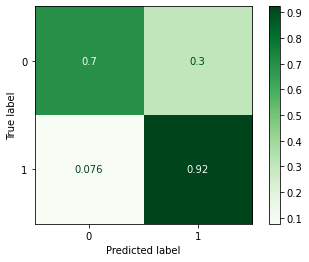

In [21]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_t, y_t)
plot_confusion_matrix(model, X_val, y_val, normalize='true', cmap='Greens')

In [22]:
importance = pd.DataFrame(model.feature_importances_, index=X_t.columns)
importance.sort_values(by=0, ascending=False).head(20)

,0
assess_score_2,0.036475
module_CCC,0.021671
module_GGG,0.019741
sum_activities_131,0.014448
sum_activities_132,0.010385
module_DDD,0.009042
sum_activities_129,0.008449
assess_score_3,0.008227
assess_score_7,0.007535
sum_activities_127,0.007428


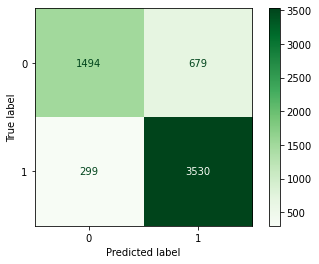

In [24]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
model.score(X_test, y_test)
plot_confusion_matrix(model, X_test, y_test, cmap='Greens')